In [17]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
from libs.simulation_tools import *
from qiskit_aer import AerSimulator
from libs.satellite import *

In [75]:
# satellite_1293 = LEOsatellite(
#     libs_dir + '/data/STARLINK_1293.txt')
# location = np.loadtxt(
#     libs_dir + '/data/ogs_loc.txt')
# year = 2021
# day = 357
# hour = 16
# minute = 29
# t = np.arange(0, 241, 10)
# second = 53 + t
# utc = 9
# latitude = location[:, 0]
# longitude = location[:, 1]
# elevation = location[:, 2]

# slant_path_lst = np.zeros(len(second))
# zenith_angle_lst = np.zeros(len(second))
# for idx in range(len(second)):
#     slant_path_lst[idx], zenith_angle_lst[idx] = satellite_1293.computeGeometricWithUser(
#         year, day, hour, minute, second[idx], utc,
#         longitude[idx], latitude[idx], elevation[idx]
#     )

# slant_path_lst = slant_path_lst * 1000

In [18]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 5) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# Bob用のリスト
# Location: Sendai
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# Alice用のリスト
# Location: Aizuwakamatsu
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

print(f'zenith_angle_bob_lst: {zenith_angle_bob_lst}')
print(f'zenith_angle_alice_lst: {zenith_angle_alice_lst}')

zenith_angle_bob_lst: [59.12231128 57.78135215 56.36761957 54.87559856 53.29942595 51.632915
 49.86960124 48.00281698 46.02580343 43.93187154 41.71462467 39.36825846
 36.88795594 34.27040004 31.51443373 28.62191847 25.59889386 22.4572817
 19.2177631  15.91559728 12.61487602  9.45040991  6.7674352   5.46569671
  6.48171328  9.04702969 12.17404931 15.46625761 18.77234156 22.02218019
 25.17778075 28.21695489 31.12682233 33.90068064 36.53619297 39.03417385
 41.39769812 43.631418   45.74103304 47.73288093 49.61362622 51.39002851
 53.06877427 54.65635906 56.15900865 57.58262988 58.93278366 60.21467415
 61.43314946]
zenith_angle_alice_lst: [59.82718274 58.55115377 57.2108359  55.80207378 54.32061774 52.76220238
 51.12265988 49.39807944 47.58502771 45.68084966 43.68407524 41.59496562
 39.41624395 37.15407265 34.81936318 32.42953934 30.01091959 27.60192231
 25.25726193 23.05298403 21.09107561 19.4996872  18.42093337 17.97820211
 18.23006705 19.14251455 20.60552853 22.47797609 24.62583646 26.939

In [64]:
num_channel_coefficients = 5000 #100000
num_qubits_per_channel_coefficient = int(1e6)

tau_zen_lst = np.array([0.81, 0.75, 0.55])
# tau_zen_lst = np.array([0.81])

In [65]:
backend = AerSimulator()

qber_simul =  np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [ ]:
# 修正後のコード
# 前提：slant_path_user_lst と slant_path_repeater_lst も同様に用意されていると仮定します。

for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    print(tau_zen)
    # 時間ステップ（jdx）でループ。リストの長さはアリスとボブで同じはずです。
    for jdx in range(len(zenith_angle_alice_lst)):
        # --- 各時間ステップで、アリスとボブのパラメータをそれぞれ設定 ---
        # アリス（alice）のパラメータ
        zenith_angle_alice_deg = zenith_angle_alice_lst[jdx]
        zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
        print(zenith_angle_alice_deg)
        slant_path_alice = slant_path_alice_lst[jdx] # アリスの距離
        sigma_R_squared_alice = rytov_variance(
            wavelength, zenith_angle_alice_rad, h_OGS, h_atm, Cn2_profile)
        w_L_alice = slant_path_alice * theta_rad
        w_Leq_squared_alice = equivalent_beam_width_squared(a, w_L_alice)

        # ボブ（Repeater）のパラメータ
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        slant_path_bob = slant_path_bob_lst[jdx] # ボブの距離
        sigma_R_squared_bob = rytov_variance(
            wavelength, zenith_angle_bob_rad, h_OGS, h_atm, Cn2_profile)
        w_L_bob = slant_path_bob * theta_rad
        w_Leq_squared_bob = equivalent_beam_width_squared(a, w_L_bob)
        
        # --- 統計的な平均を取るためのループ ---
        total_err_num = 0
        total_sifted_bit_length = 0

        # for kdx in range(int(num_channel_coefficients)):
        #     # --- アリス(User)の瞬時チャネルを計算 ---
        #     eta_ell_alice = compute_atm_loss(tau_zen, zenith_angle_alice_rad)
        #     eta_p_alice = rvs_pointing_err(
        #         mu_x, mu_y, sigma_theta_x, sigma_theta_y,
        #         slant_path_alice, theta_rad, a, w_Leq_squared_alice, size=1
        #     )
        #     I_a_alice = rvs_LN_fading(sigma_R_squared_alice, size=1)
        #     insta_eta_alice = eta_ell_alice * I_a_alice * eta_p_alice
            
        #     insta_qber_alice = qber_loss(
        #         e_0, p_dark, e_pol, p_AP, insta_eta_alice, n_s
        #     )[0]
        #     insta_yield_alice = compute_yield(
        #         insta_eta_alice, n_s, p_dark, p_AP
        #     )[0]

        #     # --- ボブ(Repeater)の瞬時チャネルを計算 ---
        #     eta_ell_bob = compute_atm_loss(tau_zen, zenith_angle_bob_rad)
        #     eta_p_bob = rvs_pointing_err(
        #         mu_x, mu_y, sigma_theta_x, sigma_theta_y,
        #         slant_path_bob, theta_rad, a, w_Leq_squared_bob, size=1
        #     )
        #     I_a_bob = rvs_LN_fading(sigma_R_squared_bob, size=1)
        #     insta_eta_bob = eta_ell_bob * I_a_bob * eta_p_bob

        #     insta_qber_bob = qber_loss(
        #         e_0, p_dark, e_pol, p_AP, insta_eta_bob, n_s
        #     )[0]
        #     insta_yield_bob = compute_yield(
        #         insta_eta_bob, n_s, p_dark, p_AP
        #     )[0]
            
        #     # --- ここから先のロジックは論文の実装によります ---
        #     # 例: 論文のBBM92プロトコルでは、両者が検出した場合のみを考える
            
        #     insta_yield_joint = insta_yield_alice * insta_yield_bob
        #     # print(f'insta yeild joint  {insta_yield_joint}') # デバッグ用

        #     # 両者が検出するイベントの数をシミュレート
        #     # insta_yield_joint を使ってイベント数を決めるのが一般的
        #     num_detected_event = np.count_nonzero(
        #         np.random.choice([1, 0], 
        #                          p=[insta_yield_joint, 1 - insta_yield_joint], size=num_qubits_per_channel_coefficient))
            
        #     print(num_detected_event)
            
        #     if (num_detected_event % 2 != 0):
        #         num_detected_event  = num_detected_event - 1
        #     # print(num_detected_event)
        #     if (num_detected_event == 0):
        #         # ゼロ割を避けるため、イベントがなかった場合は次のループへ
        #         continue
            

        #     # generate_Siftedkeyの引数をアリスとボブのものに修正
        #     part_ka, part_kb, err_num = generate_Siftedkey(
        #         num_detected_event, insta_qber_alice, insta_qber_bob, backend
        #     )
            
        #     total_err_num += err_num
        #     total_sifted_bit_length += len(part_ka)
        # (kdxループの前は同じ)

        for kdx in range(int(num_channel_coefficients)):
            # --- ステップ1: アリスとボブの瞬時チャネル状態をそれぞれ計算 ---

            # アリス(User)の瞬時チャネル
            eta_ell_alice = compute_atm_loss(tau_zen, zenith_angle_alice_rad)
            eta_p_alice = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_path_alice, theta_rad, a, w_Leq_squared_alice, size=1
            )
            I_a_alice = rvs_LN_fading(sigma_R_squared_alice, size=1)
            insta_eta_alice = eta_ell_alice * I_a_alice * eta_p_alice
            
            insta_qber_alice = qber_loss(
                e_0, p_dark, e_pol, p_AP, insta_eta_alice, n_s
            )[0]
            # アリスの個別のYieldを計算
            insta_yield_alice = compute_yield(
                insta_eta_alice, n_s, p_dark, p_AP
            )[0]

            # ボブ(Repeater)の瞬時チャネル
            eta_ell_bob = compute_atm_loss(tau_zen, zenith_angle_bob_rad)
            eta_p_bob = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_path_bob, theta_rad, a, w_Leq_squared_bob, size=1
            )
            I_a_bob = rvs_LN_fading(sigma_R_squared_bob, size=1)
            insta_eta_bob = eta_ell_bob * I_a_bob * eta_p_bob
            
            insta_qber_bob = qber_loss(
                e_0, p_dark, e_pol, p_AP, insta_eta_bob, n_s
            )[0]
            # ボブの個別のYieldを計算
            insta_yield_bob = compute_yield(
                insta_eta_bob, n_s, p_dark, p_AP
            )[0]

            # --- ステップ2: 同時検出確率を計算 ---
            insta_yield_joint = insta_yield_alice * insta_yield_bob

            # --- ステップ3: ふるい分け鍵の長さを決定 ---
            # この計算方法は統計的に正しく、効率的です
            num_detected_event = np.count_nonzero(
                np.random.choice([1, 0], 
                                 p=[insta_yield_joint, 1 - insta_yield_joint], 
                                 size=num_qubits_per_channel_coefficient)
            )
            
            
            print(num_detected_event)
            # --- ステップ4: エラーをシミュレートし、鍵を生成 ---
            
            if (num_detected_event % 2 != 0):
                num_detected_event  = num_detected_event - 1
            
            # 検出イベントがなければ、この回の試行は終了
            if (num_detected_event == 0):
                continue
            
            # generate_Siftedkeyに渡す引数は正しい
            part_ka, part_kb, err_num = generate_Siftedkey(
                num_detected_event, insta_qber_alice, insta_qber_bob, backend
            )
            
            total_err_num += err_num
            total_sifted_bit_length += len(part_ka)
        
        # ゼロ割を避ける
        if total_sifted_bit_length == 0:
            avg_qber = float('nan') # または 0 や 1 など、状況に応じて設定
        else:
            avg_qber = total_err_num / total_sifted_bit_length
            
        print(f'QBER: {avg_qber} at Alice ZD {zenith_angle_alice_deg:.2f} deg, Bob ZD {zenith_angle_bob_deg:.2f} deg')
        # qber_simulのインデックスを要確認
        qber_simul[idx][jdx] = avg_qber

0.81
59.82718273636165
0
3
8
18
18
87
35
9
6
10
82
12
5
77
0
5
18
69
10
14
2
17
33
99
45
25
3
20
26
184
5
11
19
13
53
2
18
71
51
49
43
4
755
12
15
76
22
6
20
26
2
7
52
20
12
1
35
13
14
34
65
87
11
77
116
54
2
7
125
28
10
16
16
15
15
77
6
62
17
21
61
24
13
363
4
23
61
1
32
6
17
111
38
263
19
19
4
29
1
12
8
36
10
3
26
6
39
4
11
4
16
47
10
25
19
3
4
61
20
53
45
105
27
16
14
48
14
23
23
24
30
16
15
36
5
16
12
11
5
36
23
17
135
9
32
98
67
30
32
152
12
16
95
13
26
7
16
28
6
13
21
41
23
8
3
1
20
120
46
22
0
110
21
21
35
0
31
9
39
6
3
20
21
158
6
33
8
22
21
68
65
28
8
15
25
103
1
35
5
31
64
43
22
4
10
24
4
3
30
18
12
24
15
11
51
93
26
5
52
146
3
4
2
7
133
18
5
0
64
3
28
59
18
45
1
8
28
28
69
8
83
16
13
3
15
73
22
22
21
13
5
6
30
5
11
27
8
55
10
59
10
6
14
1
14
32
14
23
16
5
18
15
22
32
66
28
29
18
95
80
6
2
16
93
4
9
5
27
12
11
39
15
36
2
69
10
17
8
12
13
25
139
15
24
2
16
29
534
34
63
16
54
46
23
34
63
10
6
35
20
7
17
8
9
18
20
0
96
18
36
48
11
37
9
2
13
25
22
36
24
44
34
56
5
32
7
8
28
29
12

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

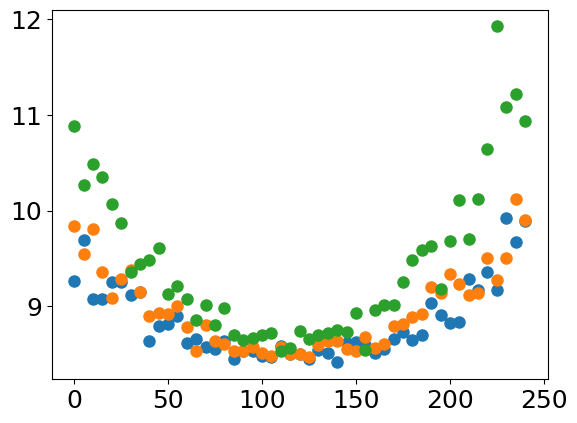

In [62]:
plt.scatter(t, qber_simul[0][:]*100)
plt.scatter(t, qber_simul[1][:]*100)
plt.scatter(t, qber_simul[2][:]*100)


In [63]:
np.save('results/qber_simul_bbm92_test1', qber_simul)

In [ ]:
skr_values =  np.zeros((len(tau_zen_lst), len(zenith_angle_lst)))

In [ ]:
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_lst)):
        zenith_angle_deg = zenith_angle_lst[jdx]
        zenith_angle_rad = np.radians(zenith_angle_deg)
        
        w_L = slant_path_lst[jdx] * theta_rad

        _, yield_values= compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
            zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )
        

        Q_1, e_1 = compute_Q_1_e_1_ex(
            sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
            zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )

        skr_values[idx][jdx] = compute_SKR(
            qber_simul[idx][jdx], yield_values, Q_1, e_1
        )



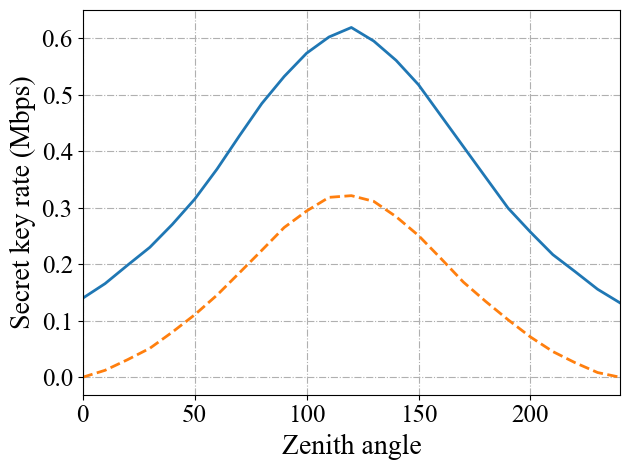

In [ ]:
plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')

plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()

In [ ]:
np.save('results/qber_simul', qber_simul)

In [ ]:
np.save('results/skr_simul', skr_values)